In [1]:
import pyspark
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, rand, row_number
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql.types import DoubleType
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
bashlite_devices = ['danmini_doorbell', 'ecobee_thermostat', 'ennio_doorbell', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera', 'samsung_SNH_1011_N_webcam',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

benign = ['danmini_doorbell', 'ecobee_thermostat', 'ennio_doorbell', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera', 'samsung_SNH_1011_N_webcam',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

bashlite_attacks = ['scan', # scanning a network for vulnerable devices
                    'junk', # sending spam data
                    'udp', # udp flood
                    'tcp', # tcp flood
                    'combo'] # sending spam data and opening connection to specific ip/port

In [4]:
first = True
bashlite_data = None
for device in bashlite_devices:
    for attack in bashlite_attacks:
        if first:
            bashlite_data = spark.read.option("inferSchema",True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/gafgyt_attacks/{attack}.csv')
            bashlite_data = bashlite_data.withColumn("label", lit(attack))
            first = False
        else:
            to_add = spark.read.option("inferSchema",True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/gafgyt_attacks/{attack}.csv')
            to_add = to_add.withColumn("label", lit(attack))
            bashlite_data = bashlite_data.union(to_add)
first = True
benign_data = None
for device in benign:
    if first:
        benign_data = spark.read.option("inferSchema",True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        first = False
    else:
        to_add = spark.read.option("inferSchema",True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        benign_data = benign_data.union(to_add)
benign_data = benign_data.withColumn('label', lit("benign"))

bashlite_data = bashlite_data.union(benign_data)

print(f'total data for prediciton modeling = {bashlite_data.count()}')

total data for prediciton modeling = 3394204


In [5]:
cols = bashlite_data.columns
new_cols = [str(i) for i in range(len(cols))]
bashlite_data = bashlite_data.toDF(*new_cols)
bashlite_data = bashlite_data.withColumnRenamed('115', 'label')

In [6]:
def pie(k, num):
    labels = [x[0] for x in k]
    
    sizes = [x[1] for x in k]

    percent = [100*(p/sum(sizes)) for p in sizes]
    
    colors=['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:gray', 'tab:olive']
    
    patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
    
    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))
    
    plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

    plt.savefig('piechart.png', bbox_inches='tight')
            
    plt.title(f'Cluster Composition for K{num}')

    plt.show()
    
def reg_kmeans(data, min_k=2, max_k=5):
    feature_list = []
    for col in data.columns:
        if col == 'label':
            continue
        else:
            feature_list.append(col)
            
    # set up feature and labels as input and output
    asmblr = VectorAssembler(inputCols=feature_list, outputCol="features")
        
    assembled_data=asmblr.transform(data)
    
    scale=StandardScaler(inputCol='features',outputCol='standardized')
    data_scale=scale.fit(assembled_data)
    data_scale_output=data_scale.transform(assembled_data)
    
    silhouette_score=[]
    
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                    metricName='silhouette', distanceMeasure='squaredEuclidean')
    
    highest = (0, 0, None, None)
    
    for i in range(min_k, max_k):
        KMeans_algo=KMeans(featuresCol='standardized', k=i)
        
        model=KMeans_algo.fit(data_scale_output)
        
        output=model.transform(data_scale_output)
        
        score=evaluator.evaluate(output)
        
        if highest[0] < score:
            highest = (score, i, output, model.clusterCenters())
        
        silhouette_score.append(score)
        
        print("Silhouette Score:",score)
    
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(min_k, max_k),silhouette_score)
    ax.set_xlabel('k')
    ax.set_ylabel('cost')
        
    return highest

In [7]:
big_sample, small_sample = bashlite_data.randomSplit([0.85, 0.15])
print(small_sample.count())

509495


Silhouette Score: 0.5393410958947754
Silhouette Score: 0.7236915499710731
Silhouette Score: 0.7361116404044162
Silhouette Score: 0.7308220182007027
Silhouette Score: 0.7492972102820427
Silhouette Score: 0.7726884148269036


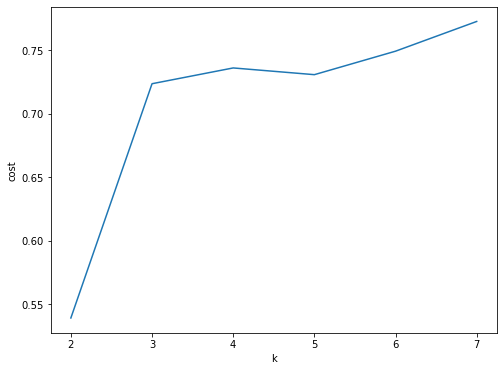

In [8]:
predictions = reg_kmeans(small_sample, 2, 8)

In [9]:
labels_clusters = predictions[2].select(['label', 'prediction'])

Total data: 509495 - Data in K0: 371452
Cluster data assigned to K0 as % of total data: 72.90591664295037%
junk : 79
tcp : 128919
benign : 61737
combo : 241
scan : 37866
udp : 142610


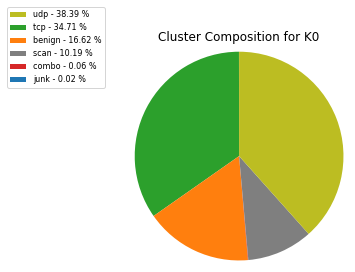




Total data: 509495 - Data in K1: 116380
Cluster data assigned to K1 as % of total data: 22.842226125869733%
junk : 39143
benign : 140
combo : 77097


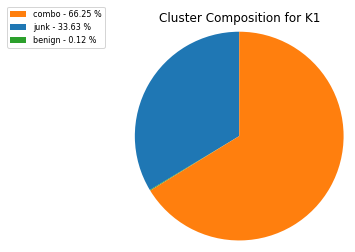




Total data: 509495 - Data in K2: 9315
Cluster data assigned to K2 as % of total data: 1.8282809448571624%
junk : 14
tcp : 20
benign : 9074
combo : 41
scan : 145
udp : 21


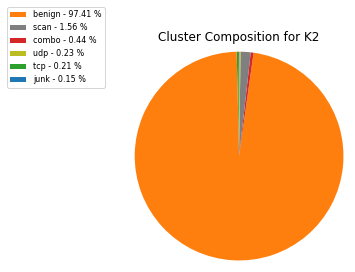




Total data: 509495 - Data in K3: 905
Cluster data assigned to K3 as % of total data: 0.17762686581811402%
junk : 21
benign : 839
combo : 30
scan : 15


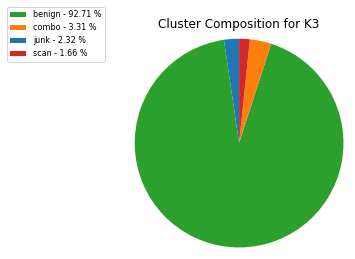




Total data: 509495 - Data in K4: 7503
Cluster data assigned to K4 as % of total data: 1.4726346676611153%
junk : 11
tcp : 41
benign : 7284
combo : 8
scan : 142
udp : 17


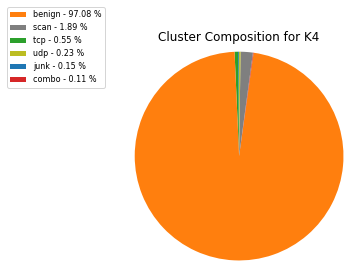




Total data: 509495 - Data in K5: 240
Cluster data assigned to K5 as % of total data: 0.04710546717828438%
benign : 240


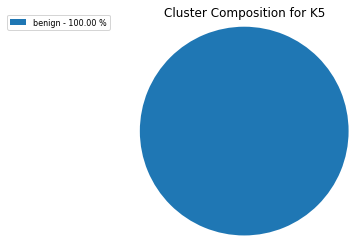




Total data: 509495 - Data in K6: 3700
Cluster data assigned to K6 as % of total data: 0.7262092856652175%
benign : 3700


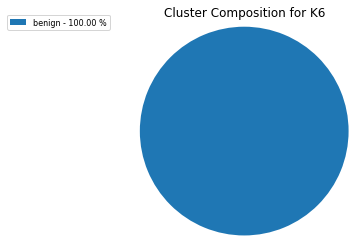

In [10]:
for i in range(predictions[1]):
    cluster = labels_clusters.filter(labels_clusters['prediction'] == i).groupBy('label').count().collect()
    assigned = sum([l[1] for l in cluster])
    total = small_sample.count()
    print(f'Total data: {total} - Data in K{i}: {assigned}')
    print(f'Cluster data assigned to K{i} as % of total data: {(assigned/total)*100}%')
    for x in cluster:
        print(f'{x[0]} : {x[1]}')
    pie(cluster, i)
    print('\n\n')

In [11]:
# print(predictions[3])